In [4]:
import tensorflow_datasets as tfds
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
split=['train[:10%]', "train[10%:25%]", "train[25%:]"], as_supervised=True,
with_info=True)

/Users/bartlomiejwozniczka/Desktop/MachineLearning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

2024-06-04 11:39:56.744957: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-04 11:39:56.747207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


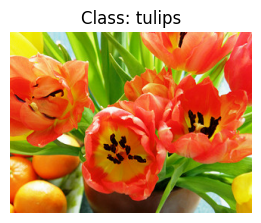

In [6]:
from matplotlib import pyplot as plt

In [7]:
from keras_tuner.src.backend.io import tf


def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


2024-06-04 11:39:58.875342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


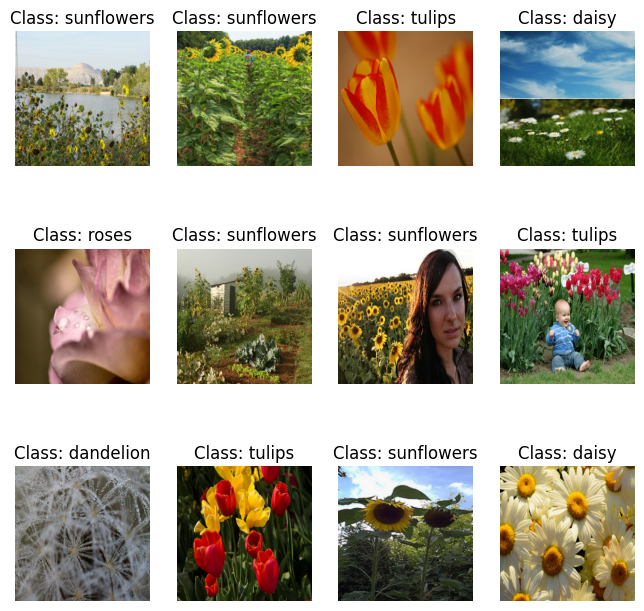

In [8]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
print(sample_batch)
for X_batch, y_batch in sample_batch: 
    for index in range(12):
        plt.subplot(3, 4, index + 1) 
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling

model = Sequential([
    Rescaling(1./255),
    Conv2D(32, (7, 7), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

/Users/bartlomiejwozniczka/Desktop/MachineLearning/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
import pickle
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.3463 - loss: 2.8592 - val_accuracy: 0.5463 - val_loss: 1.1669
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6069 - loss: 1.0059 - val_accuracy: 0.5572 - val_loss: 1.0976
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7283 - loss: 0.7289 - val_accuracy: 0.5789 - val_loss: 1.1877
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8721 - loss: 0.3733 - val_accuracy: 0.5753 - val_loss: 1.3651
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9487 - loss: 0.1975 - val_accuracy: 0.5789 - val_loss: 1.7094
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9740 - loss: 0.1097 - val_accuracy: 0.5989 - val_loss: 2.0543
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9853 - loss: 0.0630 - val_accuracy: 0.5626 - val_loss: 2.4538
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9777 - loss: 0.0750 - val_accuracy: 0.5735 - val_lo

In [12]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

with open('simple_cnn_acc.pkl', 'wb') as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)
    
model.save('simple_cnn_flowers.keras')

86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.9893 - loss: 0.0314
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.5509 - loss: 2.8476
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5920 - loss: 2.7610


In [13]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image) 
    return final_image, label

In [16]:
base_model = tf.keras.applications.xception.Xception( weights="imagenet",
include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step


In [21]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(n_classes, activation='softmax')(avg)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

for layer in base_model.layers:
    layer.trainable = True

history = model.fit(train_set, epochs=3, validation_data=valid_set)


Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.2811 - loss: 6.2665 - val_accuracy: 0.4065 - val_loss: 3.6234
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.4202 - loss: 2.8405 - val_accuracy: 0.4483 - val_loss: 2.4200
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4800 - loss: 2.2297 - val_accuracy: 0.4265 - val_loss: 2.6655
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5098 - loss: 2.0219 - val_accuracy: 0.4537 - val_loss: 2.2737
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.5479 - loss: 1.5394 - val_accuracy: 0.4701 - val_loss: 2.2510
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5803 - loss: 1.4517 - val_accuracy: 0.4809 - val_loss: 2.2876
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5829 - loss: 1.4774 - val_accuracy: 0.4646 - val_loss: 2.2706
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6314 - loss: 1.2688 - val_accuracy: 0.4918 - val_loss:

In [22]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

with open('xception_acc.pkl', 'wb') as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)
    
model.save("xception_flowers.keras")

86/86 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6776 - loss: 1.0287
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4785 - loss: 2.0901
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5573 - loss: 2.1796
